In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import seaborn as sns
import matrixprofile as mp
from sklearn.decomposition import PCA

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def mprofile(ts):
    profile = mp.compute(ts, windows=48)
    figures = mp.visualize(profile)
    ax = plt.gca()
    ax.set_title(f'Matrix profile, 1 day window')

In [4]:
data = pd.read_csv('data.csv').to_numpy()
data = (data - data.mean(axis=1).reshape(-1, 1)) / data.std(axis=1).reshape(-1, 1)

In [5]:
train_length = round(len(data) * 0.8)

train_data = torch.tensor(data[:train_length], dtype=torch.float32)
test_data = torch.tensor(data[train_length:], dtype=torch.float32)
all_data = torch.tensor(data, dtype=torch.float32)

In [6]:
train_loader = DataLoader(TensorDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=16, shuffle=False)
all_loader = DataLoader(TensorDataset(all_data), batch_size=16, shuffle=True)

In [7]:
class GRUEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUEncoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=num_layers) # B x L x 2 * hid, 2 x B x hid

    def forward(self, x):
        x, h = self.gru(x)
        return h

class GRUDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUDecoder, self).__init__()
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True) # B x L x hid, 1 x B x hid
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, h, seq_len=31):
        x = torch.zeros((h.shape[1], seq_len, h.shape[2]), device=h.device, requires_grad=True)
        x, _ = self.gru(x, h)
        x = self.layer_norm(x)
        x = self.out(x)
        return x

class GRUAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(GRUAutoencoder, self).__init__()
        self.encoder = GRUEncoder(input_size, hidden_size, num_layers)
        self.decoder = GRUDecoder(input_size, hidden_size, num_layers)
    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        return x

In [8]:
model = GRUAutoencoder(input_size=48, hidden_size=48, num_layers=1).to(device)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [10]:
all_train_losses = []
train_losses = []
test_losses = []

In [11]:
epochs = 300

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in train_loader:
        batch = batch[0].view(-1, 31, 48).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_train_losses.append(loss.item())
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')
    train_losses.append(avg_loss)
    
    model.eval()
    avg_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].view(-1, 31, 48).to(device)
            preds = model(batch)
            loss = criterion(preds, batch)
            
            avg_test_loss += loss.item()
    avg_test_loss /= len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Test Loss: {avg_test_loss:.4f}')

Epoch 1, Loss: 0.8070
Test Loss: 0.6162
Epoch 2, Loss: 0.6011
Test Loss: 0.6013
Epoch 3, Loss: 0.5894
Test Loss: 0.5844
Epoch 4, Loss: 0.5543
Test Loss: 0.5204
Epoch 5, Loss: 0.5127
Test Loss: 0.5068
Epoch 6, Loss: 0.5046
Test Loss: 0.5038
Epoch 7, Loss: 0.5009
Test Loss: 0.4996
Epoch 8, Loss: 0.4978
Test Loss: 0.4962
Epoch 9, Loss: 0.4948
Test Loss: 0.4915
Epoch 10, Loss: 0.4858
Test Loss: 0.4853
Epoch 11, Loss: 0.4803
Test Loss: 0.4797
Epoch 12, Loss: 0.4752
Test Loss: 0.4718
Epoch 13, Loss: 0.4688
Test Loss: 0.4658
Epoch 14, Loss: 0.4640
Test Loss: 0.4603
Epoch 15, Loss: 0.4569
Test Loss: 0.4554
Epoch 16, Loss: 0.4541
Test Loss: 0.4507
Epoch 17, Loss: 0.4475
Test Loss: 0.4464
Epoch 18, Loss: 0.4428
Test Loss: 0.4418
Epoch 19, Loss: 0.4397
Test Loss: 0.4382
Epoch 20, Loss: 0.4365
Test Loss: 0.4345
Epoch 21, Loss: 0.4317
Test Loss: 0.4311
Epoch 22, Loss: 0.4322
Test Loss: 0.4285
Epoch 23, Loss: 0.4296
Test Loss: 0.4255
Epoch 24, Loss: 0.4264
Test Loss: 0.4231
Epoch 25, Loss: 0.4241
Te

KeyboardInterrupt: 

In [40]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'{name} grad: {param.grad.abs().mean()}')

encoder.gru.weight_ih_l0 grad: 0.0011836212361231446
encoder.gru.weight_hh_l0 grad: 0.00038031741860322654
encoder.gru.bias_ih_l0 grad: 0.0019096311880275607
encoder.gru.bias_hh_l0 grad: 0.0012476334813982248
decoder.gru.weight_ih_l0 grad: 0.0
decoder.gru.weight_hh_l0 grad: 0.001043937518261373
decoder.gru.bias_ih_l0 grad: 0.0046655843034386635
decoder.gru.bias_hh_l0 grad: 0.003967411816120148
decoder.layer_norm.weight grad: 0.0018784970743581653
decoder.layer_norm.bias grad: 0.0012324313865974545
decoder.out.weight grad: 0.0023527571465820074
decoder.out.bias grad: 0.0019721644930541515


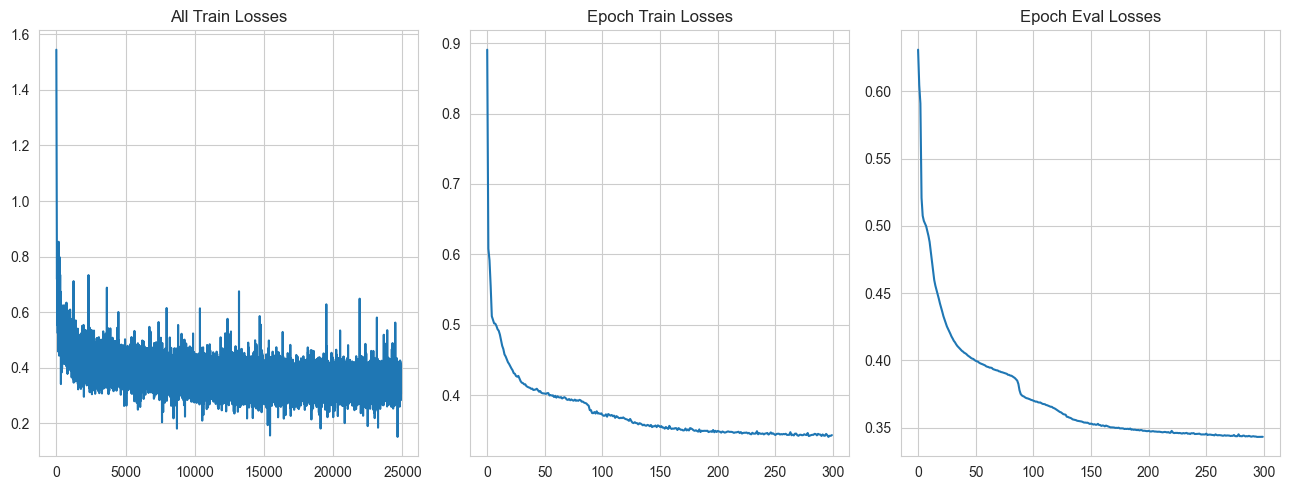

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].plot(all_train_losses)
axes[0].set_title('All Train Losses')
axes[1].plot(train_losses)
axes[1].set_title('Epoch Train Losses')
axes[2].plot(test_losses)
axes[2].set_title('Epoch Eval Losses')
plt.tight_layout()
plt.show()

In [51]:
model = GRUAutoencoder(input_size=48, hidden_size=48, num_layers=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [52]:
epochs = 300

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in all_loader:
        batch = batch[0].view(-1, 31, 48).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.9496
Epoch 2, Loss: 0.7479
Epoch 3, Loss: 0.7297
Epoch 4, Loss: 0.6545
Epoch 5, Loss: 0.6279
Epoch 6, Loss: 0.6226
Epoch 7, Loss: 0.6183
Epoch 8, Loss: 0.6113
Epoch 9, Loss: 0.5997
Epoch 10, Loss: 0.5892
Epoch 11, Loss: 0.5797
Epoch 12, Loss: 0.5696
Epoch 13, Loss: 0.5612
Epoch 14, Loss: 0.5548
Epoch 15, Loss: 0.5494
Epoch 16, Loss: 0.5451
Epoch 17, Loss: 0.5406
Epoch 18, Loss: 0.5372
Epoch 19, Loss: 0.5330
Epoch 20, Loss: 0.5298
Epoch 21, Loss: 0.5264
Epoch 22, Loss: 0.5230
Epoch 23, Loss: 0.5211
Epoch 24, Loss: 0.5187
Epoch 25, Loss: 0.5169
Epoch 26, Loss: 0.5151
Epoch 27, Loss: 0.5132
Epoch 28, Loss: 0.5116
Epoch 29, Loss: 0.5099
Epoch 30, Loss: 0.5089
Epoch 31, Loss: 0.5074
Epoch 32, Loss: 0.5062
Epoch 33, Loss: 0.5047
Epoch 34, Loss: 0.5038
Epoch 35, Loss: 0.5034
Epoch 36, Loss: 0.5022
Epoch 37, Loss: 0.5011
Epoch 38, Loss: 0.5012
Epoch 39, Loss: 0.5002
Epoch 40, Loss: 0.4997
Epoch 41, Loss: 0.4987
Epoch 42, Loss: 0.4982
Epoch 43, Loss: 0.4978
Epoch 44, Loss: 0.49

In [63]:
errors = []
encoded = []
reconstructed = []
with torch.no_grad():
    for sample in all_data:
        inputs = sample.view(-1, 31, 48).to(device)
        res = model(inputs).cpu().detach().flatten()
        reconstruction_error = criterion(res, sample)
        errors.append(reconstruction_error.cpu().detach().numpy())
        
        features = model.encoder(inputs).view(-1)
        encoded.append(features.cpu().detach().numpy())
        
        reconstructed.append(res.view(-1).cpu().detach().numpy())
errors = np.array(errors)
encoded = np.array(encoded)
reconstructed = np.array(reconstructed)

In [65]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()

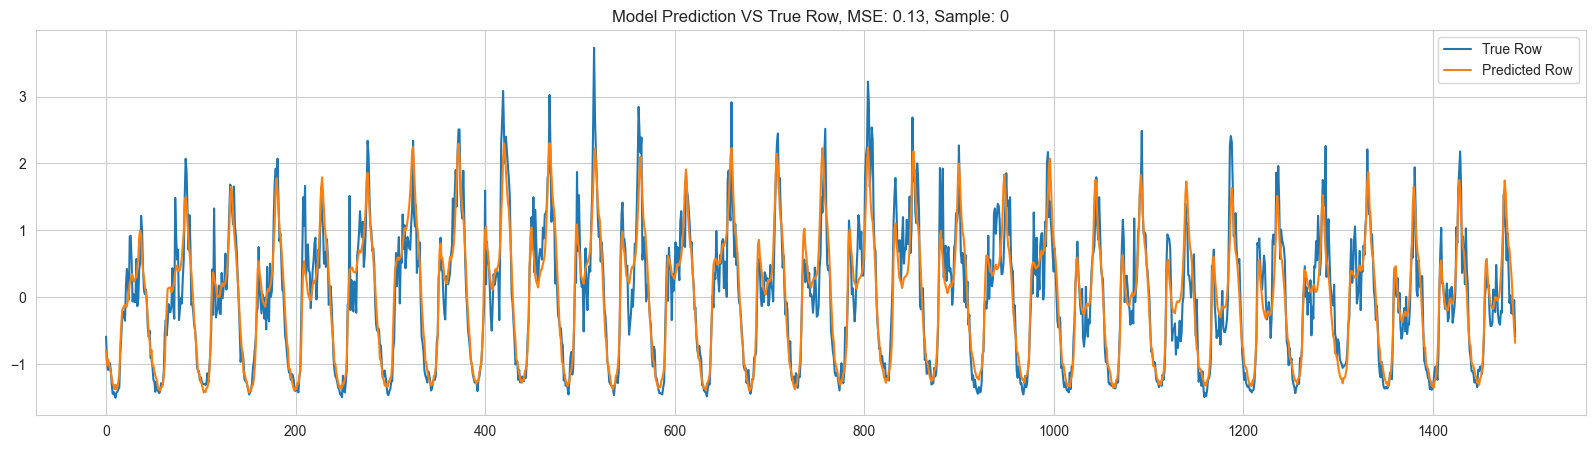

In [89]:
plot_sample(0)

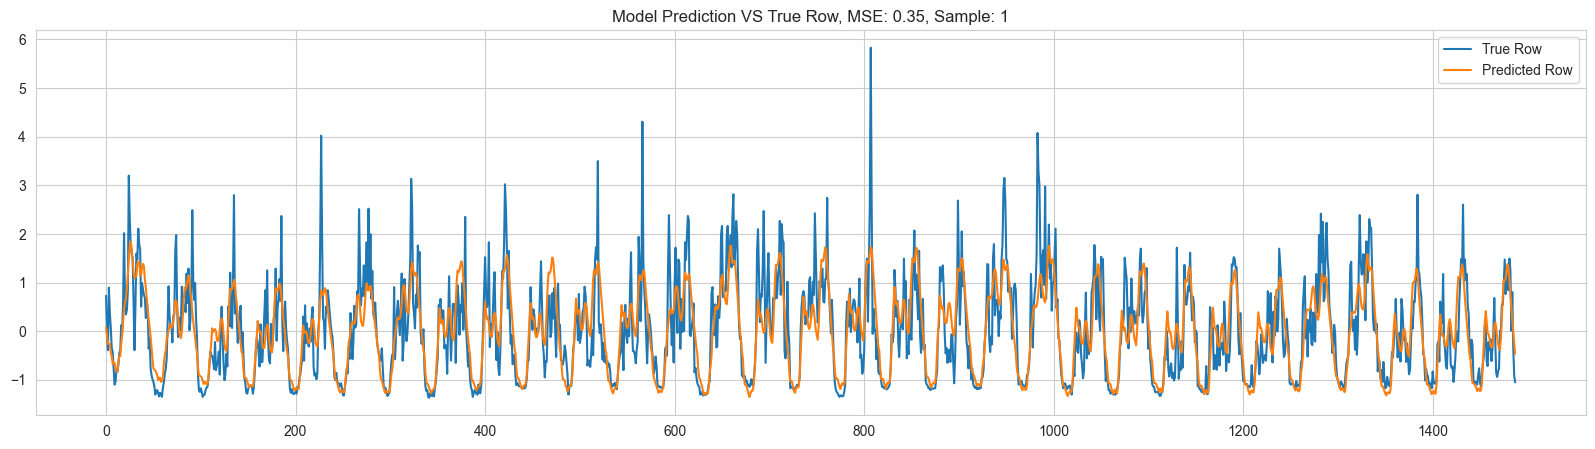

In [66]:
plot_sample(1)

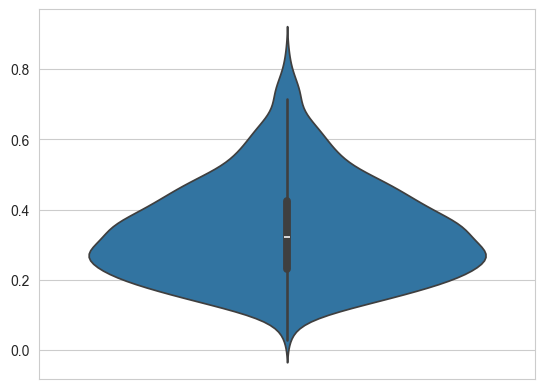

In [67]:
sns.violinplot(errors)
plt.show()

In [68]:
np.quantile(errors, 0.99)

0.7382897102832794

In [69]:
np.column_stack((np.argsort(-errors), -np.sort(-errors)))

array([[1.57800000e+03, 8.57895136e-01],
       [3.94000000e+02, 8.32433939e-01],
       [1.16800000e+03, 8.15387428e-01],
       ...,
       [1.10200000e+03, 4.85871993e-02],
       [6.54000000e+02, 3.36600877e-02],
       [2.23000000e+02, 3.03117074e-02]])

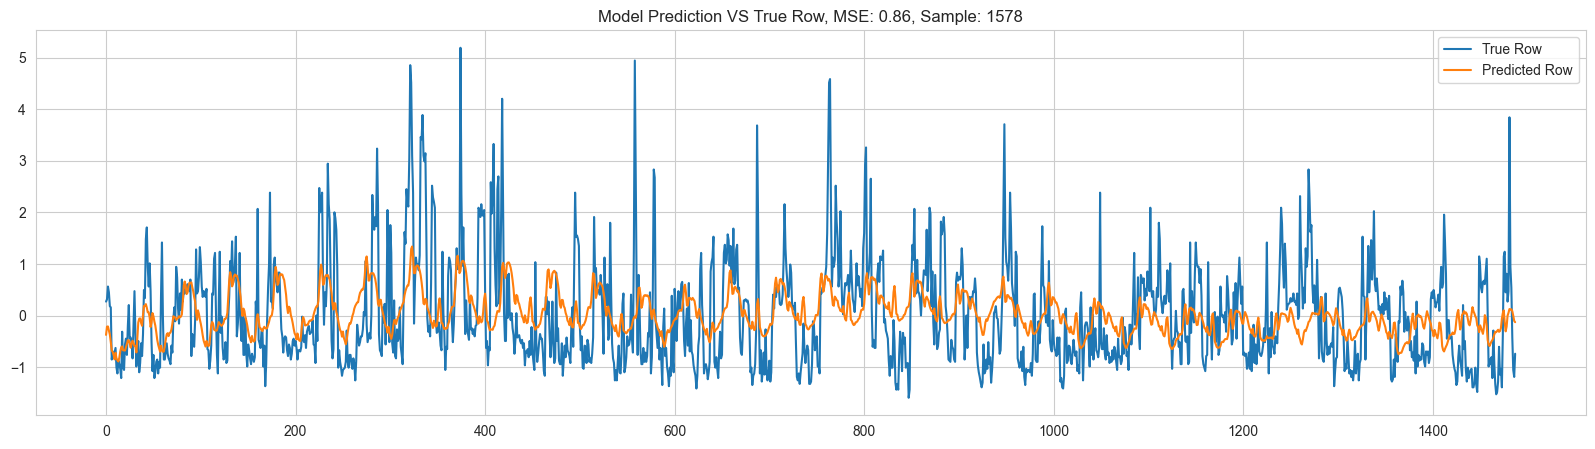

In [72]:
plot_sample(1578)

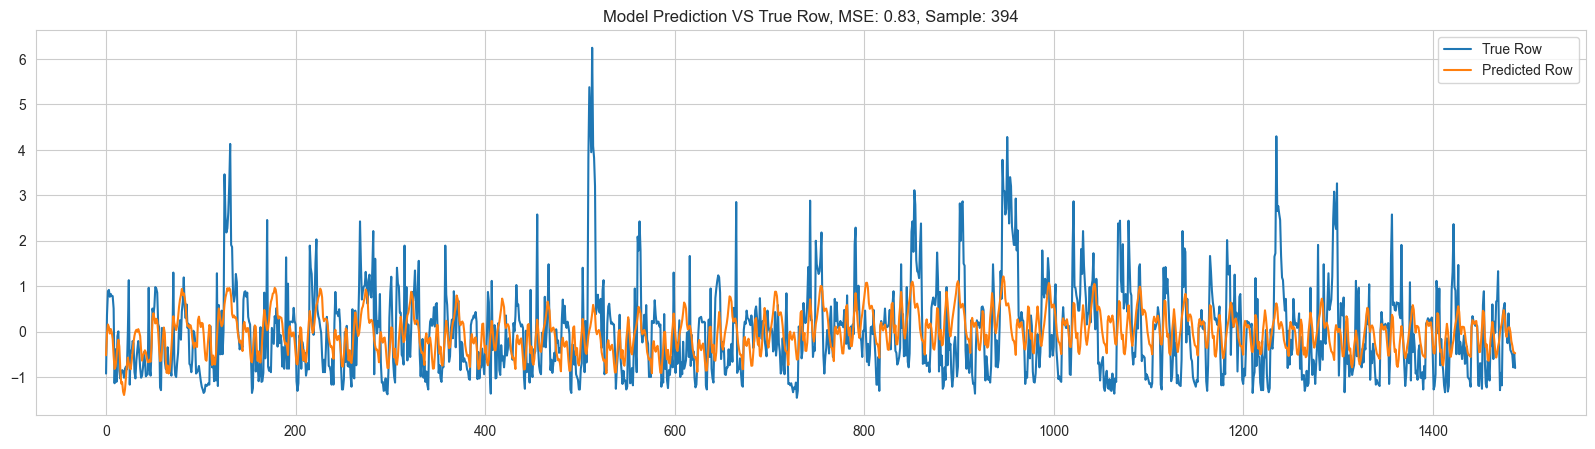

In [73]:
plot_sample(394)

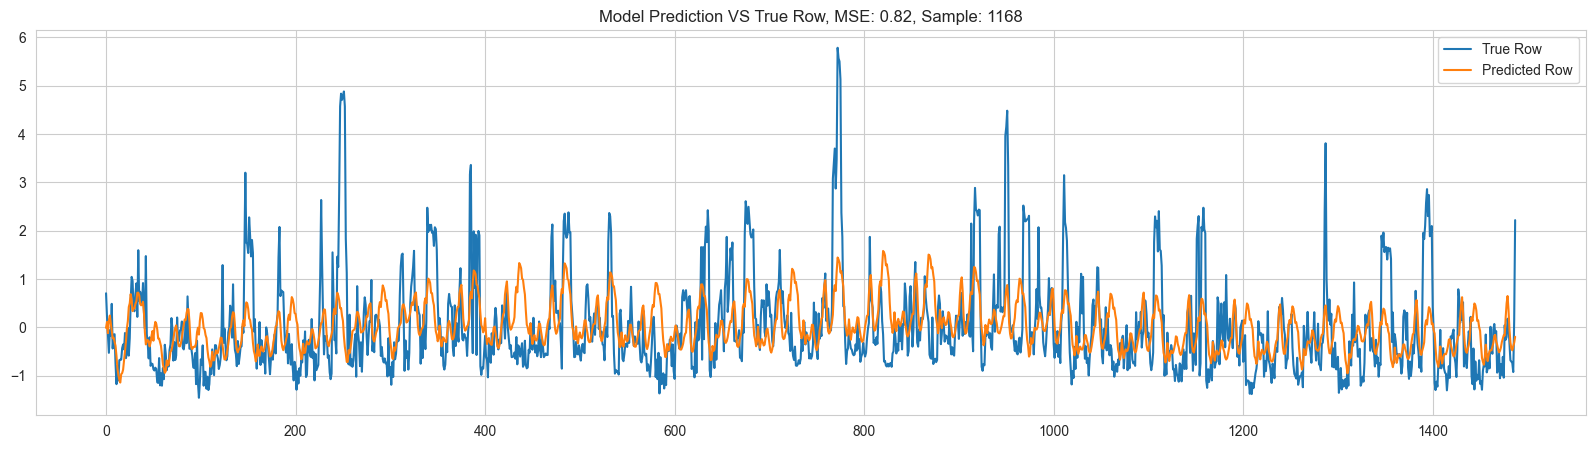

In [74]:
plot_sample(1168)

# ------------------------------------

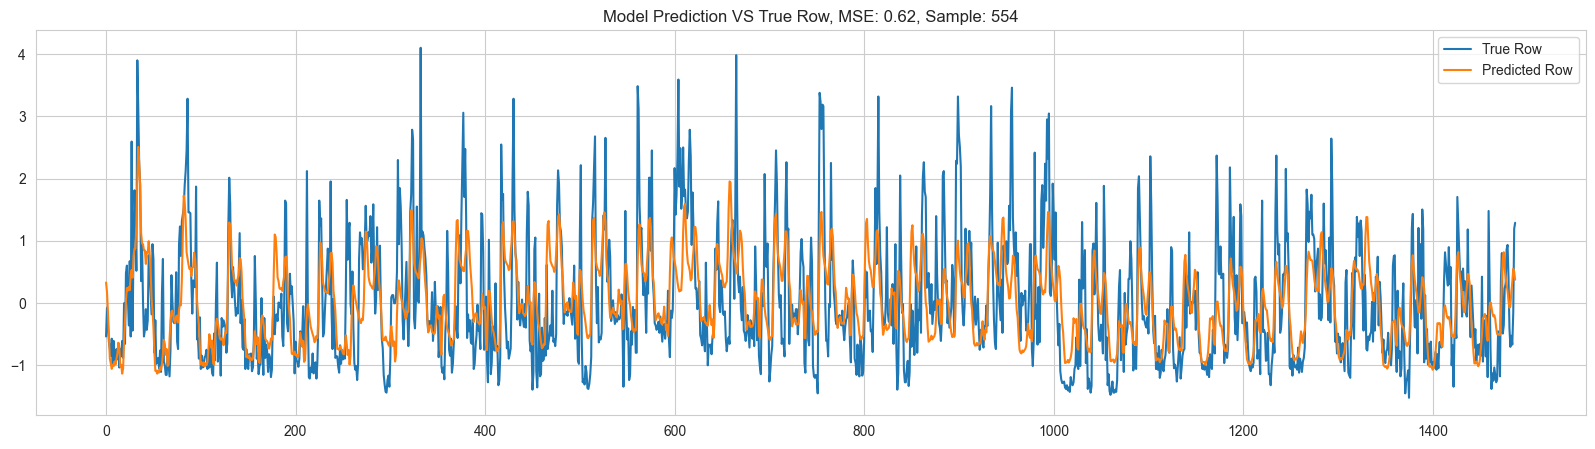

In [102]:
plot_sample(554)

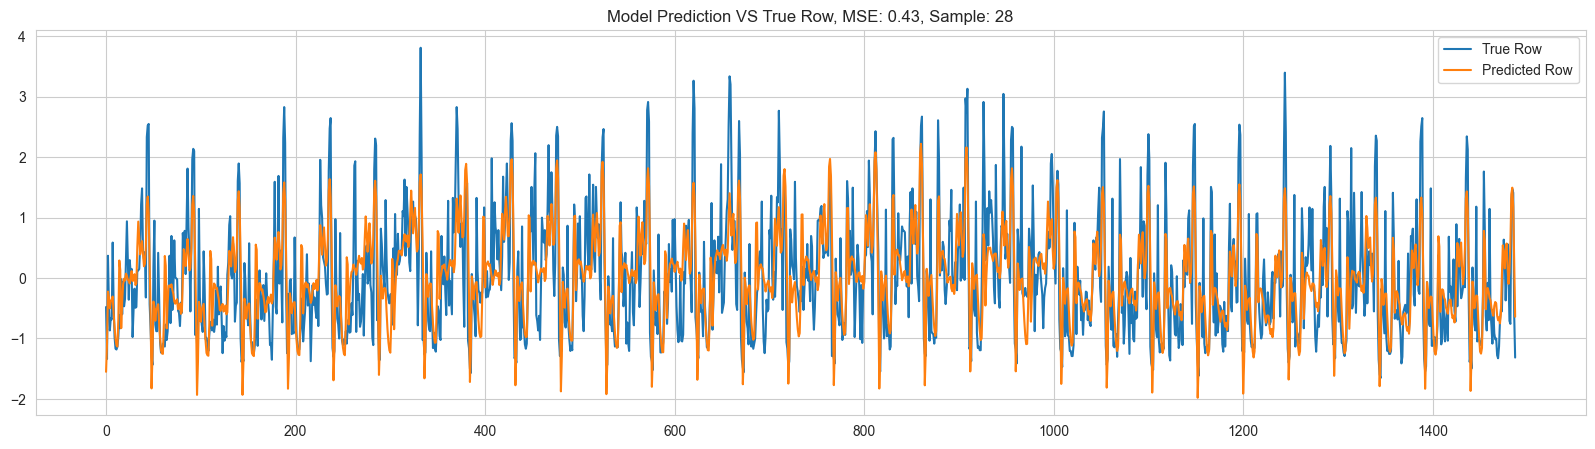

In [93]:
plot_sample(28)

In [71]:
# torch.save(model.state_dict(), './models/rec_autoenc_subsec.pt')

In [75]:
encoded_norm = (encoded - encoded.mean(axis=0)) / encoded.std(axis=0)

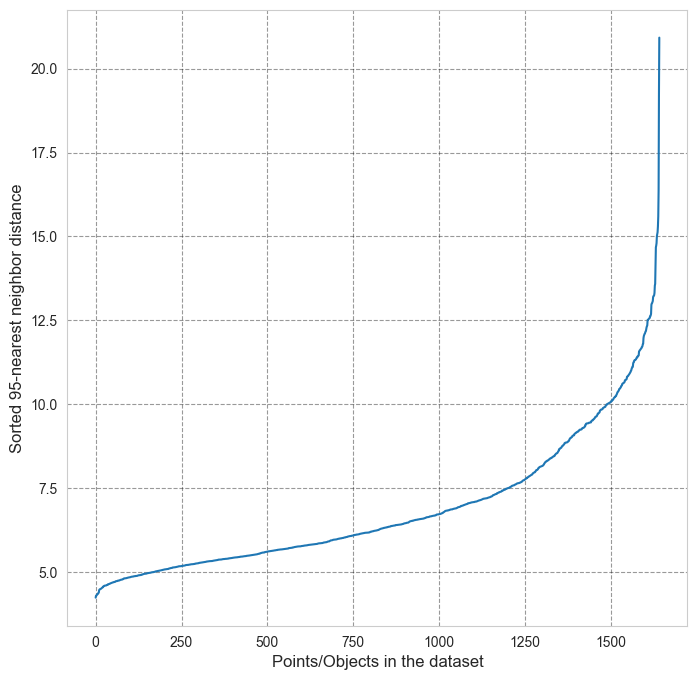

In [76]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * encoded_norm.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=encoded_norm, k=k)

In [85]:
from sklearn.cluster import DBSCAN

# Создаем объект DBSCAN
dbscan = DBSCAN(eps=11, min_samples=35)

# Проводим кластеризацию данных
clusters = dbscan.fit_predict(encoded_norm)

# Ищем объекты, отнесенные к кластеру -1 (это аномалии)
anomalies_indices = np.where(clusters == -1)[0]
anomalies_indices

# 1168, 1178, 1633

array([  28,   70,  877, 1066, 1168, 1178, 1189, 1262, 1508, 1633],
      dtype=int64)

In [108]:
anomalies_indices.reshape(-1, 1)

array([[  28],
       [  70],
       [ 877],
       [1066],
       [1168],
       [1178],
       [1189],
       [1262],
       [1508],
       [1633]], dtype=int64)

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded)
explained_variance = pca.explained_variance_ratio_

explained_variance

array([0.20726839, 0.10538841], dtype=float32)

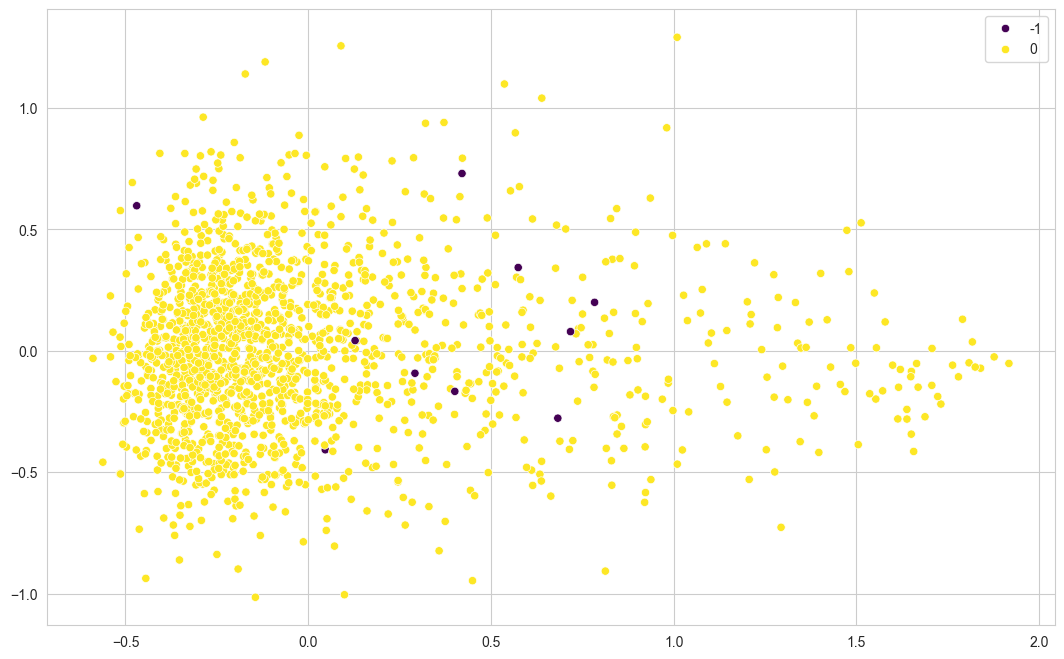

In [82]:
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=clusters, palette='viridis')
plt.gcf().set_size_inches(13, 8)
plt.show()

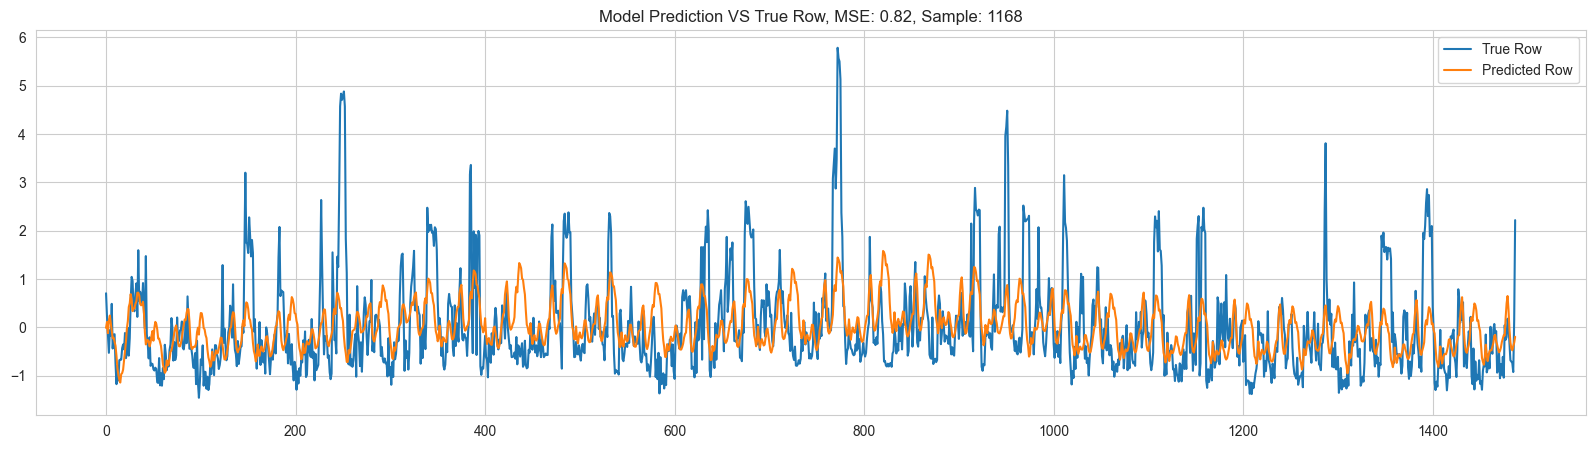

In [86]:
plot_sample(1168)

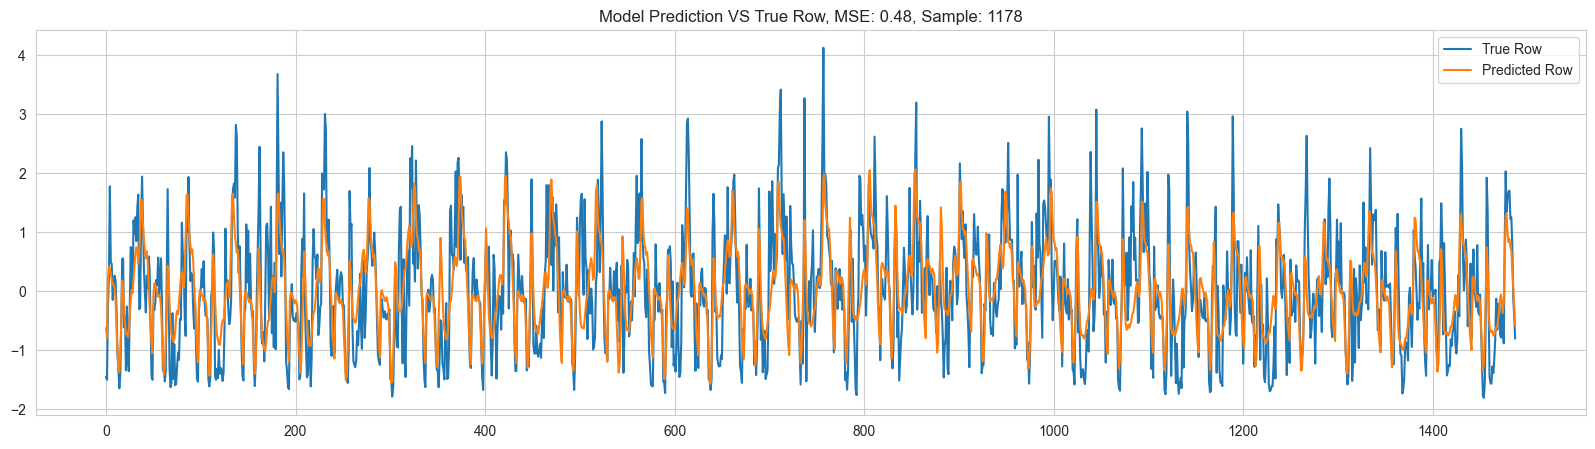

In [87]:
plot_sample(1178)

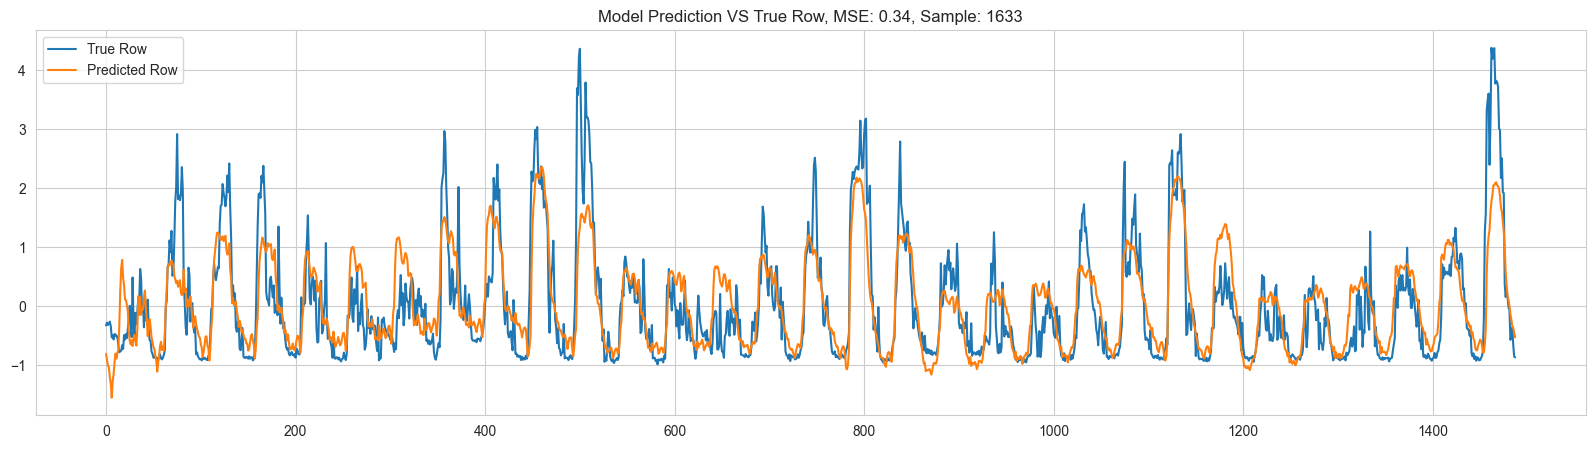

In [88]:
plot_sample(1633)

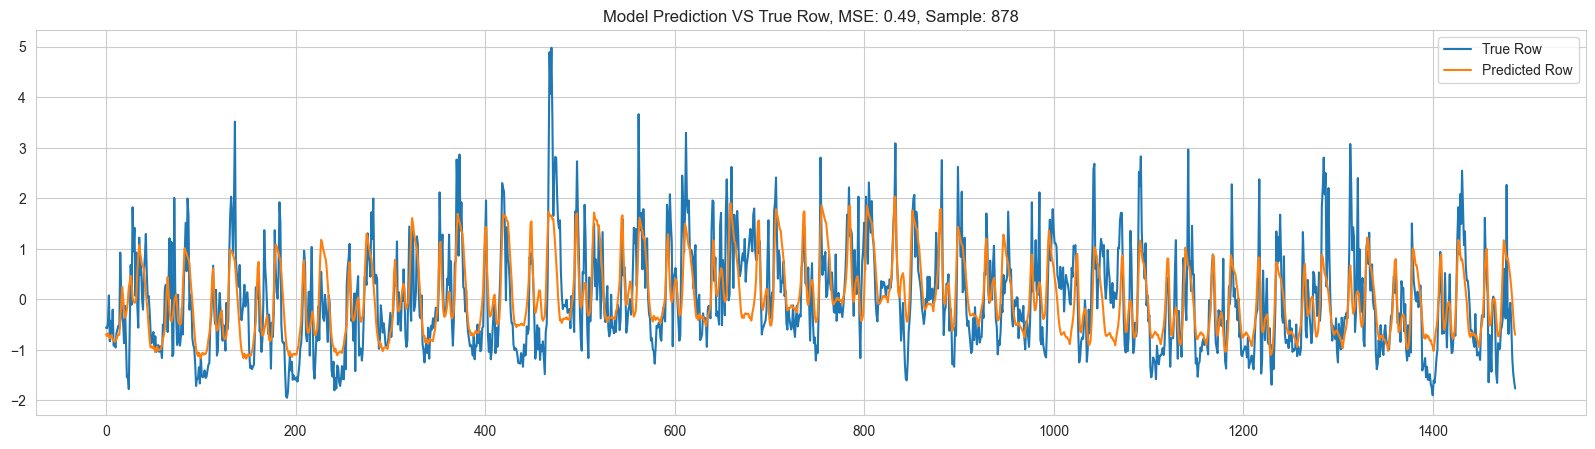

In [104]:
plot_sample(878)